In [56]:
#!pip install pandas_datareader
#!pip install seaborn


In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [58]:
def format_quarters(x, pos):
    date = mdates.num2date(x)  # Convert matplotlib date to datetime
    quarter = (date.month - 1) // 3 + 1  # Calculate the quarter
    if quarter == 1:  # Show year only for Q1
        return f"{date.year}-Q{quarter}"
    else:  # Show only the quarter for Q2, Q3, Q4
        return f"Q{quarter}"

            CPIAUCSL  Quarterly CPI  Annual Inflation Rate
DATE                                                      
1988-06-01   118.000     117.566667               4.562353
1988-09-01   119.500     119.000000               4.847178
1988-12-01   120.700     120.300000               4.346052
1989-03-01   122.200     121.666667               4.518577
1989-06-01   124.100     123.633333               6.414052
...              ...            ...                    ...
2023-12-01   308.735     308.158333               2.756113
2024-03-01   312.107     310.974333               3.638664
2024-06-01   313.131     313.095667               2.719364
2024-09-01   314.851     314.182667               1.386308
2024-12-01   317.603     316.538667               2.988338

[147 rows x 3 columns]


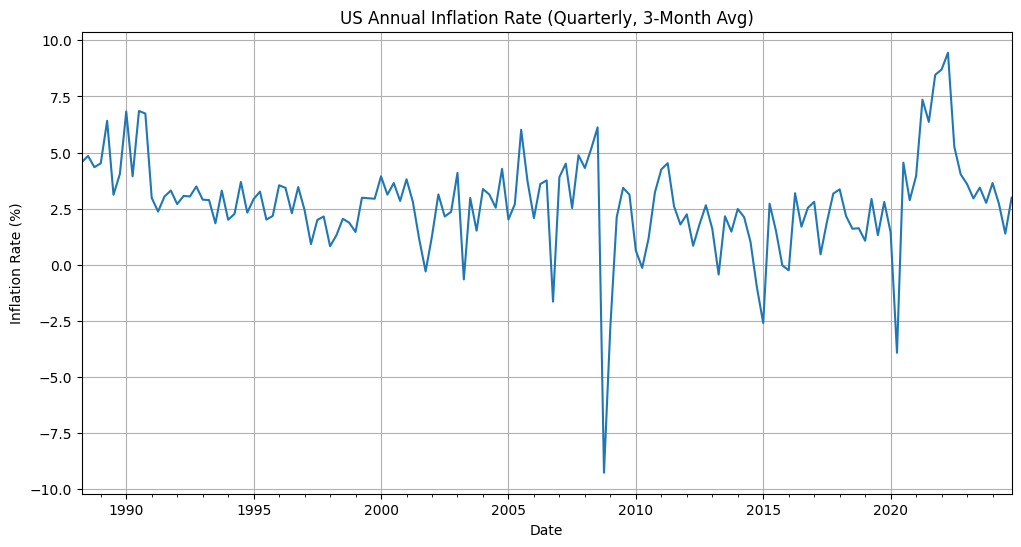

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas_datareader import data as web

# Define date range
start_date = datetime.datetime(1988, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

# Download CPI data
df_cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
df_cpi.dropna(inplace=True)

# Create a column for quarterly CPI using 3-month average (only at quarter-end months)
df_cpi['Quarterly CPI'] = df_cpi['CPIAUCSL'].rolling(window=3).mean()

# Keep only the months that are quarter-ends: March, June, September, December
df_cpi_quarterly = df_cpi[df_cpi.index.month.isin([3, 6, 9, 12])].copy()

# Compute annualized inflation rate
df_cpi_quarterly['Annual Inflation Rate'] = 400 * np.log(
    df_cpi_quarterly['Quarterly CPI'] / df_cpi_quarterly['Quarterly CPI'].shift(1)
)

df_inflation = df_cpi_quarterly.dropna()

print(df_inflation)
# Plot
df_inflation['Annual Inflation Rate'].plot(title='US Annual Inflation Rate (Quarterly, 3-Month Avg)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()


In [60]:
df_inflation

,CPIAUCSL,Quarterly CPI,Annual Inflation Rate
DATE,,,
1988-06-01,118.000,117.566667,4.562353
1988-09-01,119.500,119.000000,4.847178
1988-12-01,120.700,120.300000,4.346052
1989-03-01,122.200,121.666667,4.518577
1989-06-01,124.100,123.633333,6.414052
...,...,...,...
2023-12-01,308.735,308.158333,2.756113
2024-03-01,312.107,310.974333,3.638664
2024-06-01,313.131,313.095667,2.719364


In [61]:
# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
print(adf_output)



Augmented Dickey-Fuller Test Results:
Test Statistic                -7.662569e+00
p-value                        1.673539e-11
# of Lags Used                 0.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


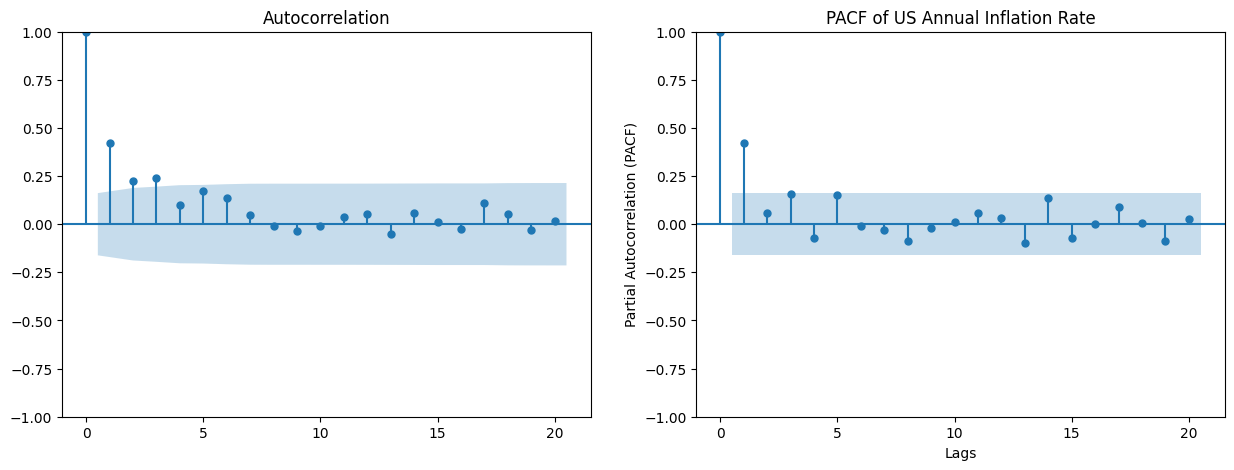

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF for the annual inflation rate
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
# Plot the PACF for the annual inflation rate
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
plt.title("PACF of US Annual Inflation Rate")
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation (PACF)')
plt.show()


In [63]:
# Fit an AR(1) model
model_ar1 = AutoReg(df_inflation['Annual Inflation Rate'], lags=1).fit()
print("AR(1) Model Summary:")
print(model_ar1.summary())

# Choose the lag order based on the PACF plot
p = 6

# Fit an AR(p) model
model_arp = AutoReg(df_inflation['Annual Inflation Rate'], lags=p).fit()
print(f"\nAR({p}) Model Summary:")
print(model_arp.summary())

AR(1) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -307.163
Method:                  Conditional MLE   S.D. of innovations              1.984
Date:                   Tue, 15 Apr 2025   AIC                            620.326
Time:                           11:35:51   BIC                            629.277
Sample:                       09-01-1988   HQIC                           623.963
                            - 12-01-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5609      0.262      5.966      0.000       1.048       2.074
Annual Inflation Rate.L1     0.4231      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


In [64]:
def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    print(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    print(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -307.163
Method:                  Conditional MLE   S.D. of innovations              1.984
Date:                   Tue, 15 Apr 2025   AIC                            620.326
Time:                           11:35:51   BIC                            629.277
Sample:                       09-01-1988   HQIC                           623.963
                            - 12-01-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5609      0.262      5.966      0.000       1.048       2.074
Annual Inflation Rate.L1     0.4231      0.075      5.658      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

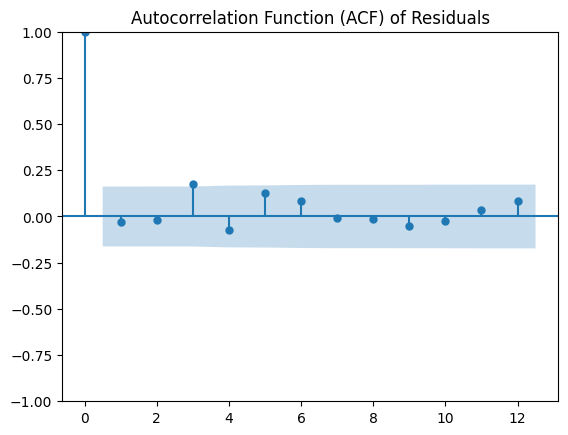

Ljung-Box Test Results for Residuals:
     lb_stat  lb_pvalue
10  9.725454   0.464901


In [65]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=1)

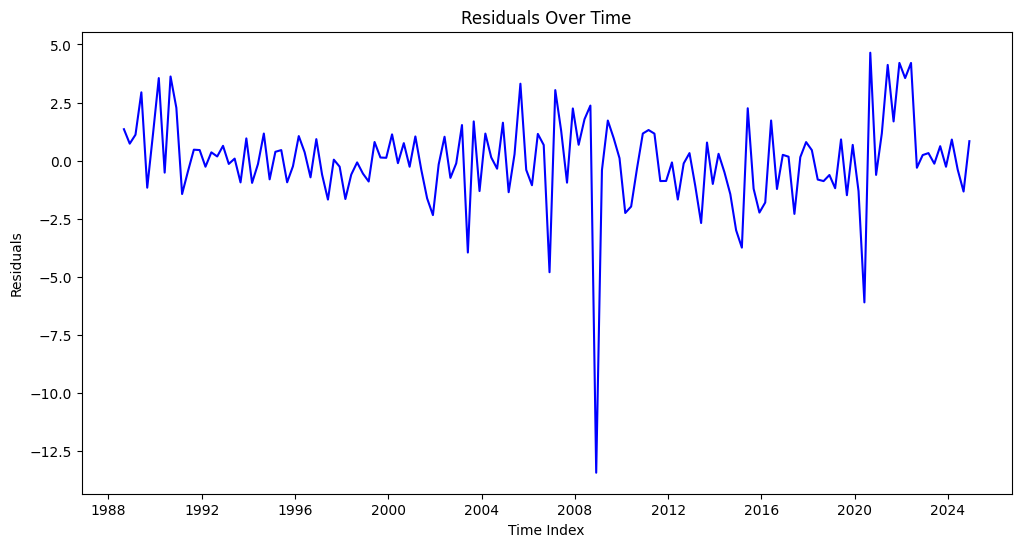

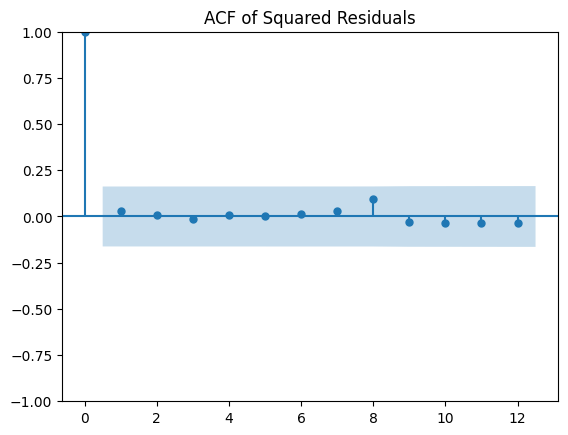

ARCH Test Results:
LM Statistic      1.818706
p-value           0.997550
F-statistic       0.169426
F-test p-value    0.997991
dtype: float64


In [66]:
# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


In [67]:
results = []
for i in range(1, 10):  # AR models from lag 1 to 9

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=620.33, BIC=629.28
AR(2): AIC=618.15, BIC=630.05
AR(3): AIC=613.18, BIC=628.03
AR(4): AIC=611.09, BIC=628.87
AR(5): AIC=604.28, BIC=624.97
AR(6): AIC=602.68, BIC=626.27
AR(7): AIC=601.19, BIC=627.66
AR(8): AIC=596.67, BIC=626.01
AR(9): AIC=595.46, BIC=627.66

Best Model (AIC): Lag 9, AIC=595.46, BIC=627.66
Best Model (BIC): Lag 5, AIC=604.28, BIC=624.97


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Fra

In [68]:
# Define Train and Test Sets Using Boolean Indexing
train_data = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = df_inflation.loc[df_inflation.index >= '2022-06-01']

In [69]:
# Fit an AR(1) model
model_ar1 = AutoReg(train_data['Annual Inflation Rate'], lags=1).fit()
print("\nAR(1) Model Summary:")
print(model_ar1.summary())

# # Fit an AR(3) model
# model_ar3 = AutoReg(train_data['Annual Inflation Rate'], lags=3).fit()
# print("\nAR(3) Model Summary:")
# print(model_ar3.summary())

# # Fit an AR(6) model
# model_ar6 = AutoReg(train_data['Annual Inflation Rate'], lags=6).fit()
# print("\nAR(6) Model Summary:")
# print(model_ar6.summary())

# Fit an AR(9) model
model_ar9 = AutoReg(train_data['Annual Inflation Rate'], lags=9).fit()
print("\nAR(9) Model Summary:")
print(model_ar9.summary())



AR(1) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                        AutoReg(1)   Log Likelihood                -286.561
Method:                  Conditional MLE   S.D. of innovations              2.021
Date:                   Tue, 15 Apr 2025   AIC                            579.122
Time:                           11:35:51   BIC                            587.838
Sample:                       09-01-1988   HQIC                           582.664
                            - 03-01-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.6243      0.275      5.917      0.000       1.086       2.162
Annual Inflation Rate.L1     0.3850      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


In [70]:
# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]

# Forecast using the AR(1) model
pred_ar1 = model_ar1.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Forecast using the AR(3) model
# pred_ar3 = model_ar3.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Forecast using the AR(6) model
# pred_ar6 = model_ar6.predict(start=forecast_start, end=forecast_end, dynamic=True)
pred_ar9 = model_ar9.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Calculate RMSE for each model
rmse_ar1 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar1))
# rmse_ar3 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar3))
# rmse_ar6 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar6))
rmse_ar9 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar9))

print("\nForecast Performance:")
print("AR(1) RMSE: {:.4f}".format(rmse_ar1))
# print("AR(3) RMSE: {:.4f}".format(rmse_ar3))
# print("AR(6) RMSE: {:.4f}".format(rmse_ar6))
print("AR(9) RMSE: {:.4f}".format(rmse_ar9))


Forecast Performance:
AR(1) RMSE: 1.5978
AR(9) RMSE: 1.5598


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


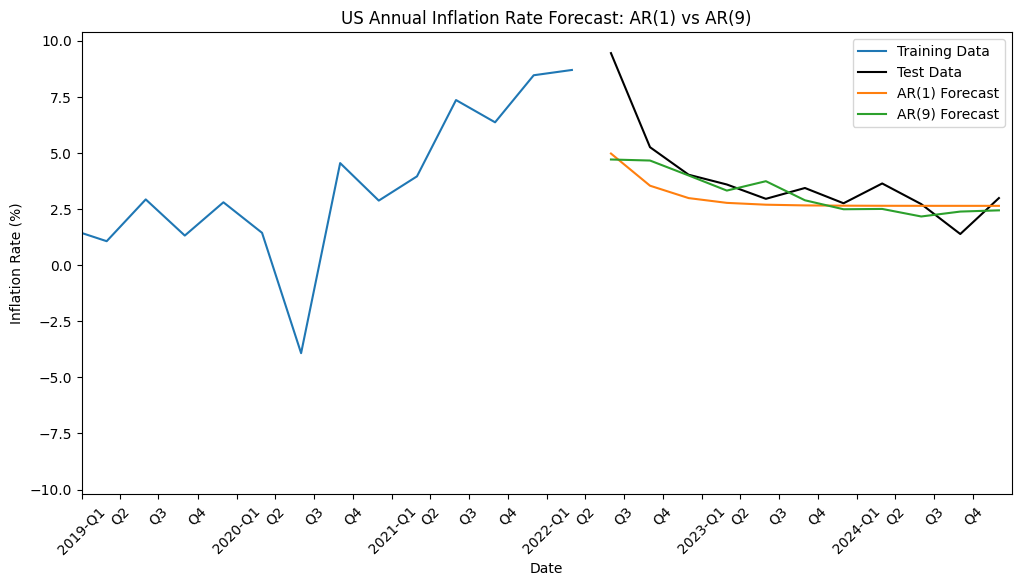

In [71]:
# Actual vs Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar1.index, pred_ar1, label='AR(1) Forecast')
plt.plot(pred_ar9.index, pred_ar9, label='AR(9) Forecast')
plt.title("US Annual Inflation Rate Forecast: AR(1) vs AR(9)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])
# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

Exogenous variables

In [72]:
# Fit an ARDL model with exogenous variables
df_inflation_quarterly = df_inflation.resample('QE').last()
df_inflation_quarterly

,CPIAUCSL,Quarterly CPI,Annual Inflation Rate
DATE,,,
1988-06-30,118.000,117.566667,4.562353
1988-09-30,119.500,119.000000,4.847178
1988-12-31,120.700,120.300000,4.346052
1989-03-31,122.200,121.666667,4.518577
1989-06-30,124.100,123.633333,6.414052
...,...,...,...
2023-12-31,308.735,308.158333,2.756113
2024-03-31,312.107,310.974333,3.638664
2024-06-30,313.131,313.095667,2.719364


In [73]:
df_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
# Compute quarterly GDP change (log difference * 100)
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['GDPC1']).diff() * 100
df_gdp.index = pd.to_datetime(df_gdp.index)
# Convert to quarterly period and then get the quarter-end timestamp
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)
df_gdp

,GDPC1,Quarterly GDP Change
DATE,,
1988-06-30,9490.594,1.305474
1988-09-30,9546.206,0.584260
1988-12-31,9673.405,1.323657
1989-03-31,9771.725,1.011264
1989-06-30,9846.293,0.760203
...,...,...
2023-12-31,22960.600,0.785579
2024-03-31,23053.545,0.403985
2024-06-30,23223.906,0.736263


In [74]:
df_interest = web.DataReader('GS10', 'fred', start_date, end_date)
df_interest_quarterly = df_interest.resample('QE').mean()
df_interest_quarterly.rename(columns={'GS10': 'Interest Rate Quarterly'}, inplace=True)
df_interest_quarterly

,Interest Rate Quarterly
DATE,
1988-03-31,8.416667
1988-06-30,8.910000
1988-09-30,9.100000
1988-12-31,8.956667
1989-03-31,9.206667
...,...
2023-12-31,4.440000
2024-03-31,4.160000
2024-06-30,4.443333


In [75]:
df_unemp = web.DataReader('UNRATE', 'fred', start_date, end_date)
df_unemp_quarterly = df_unemp.resample('QE').mean()
df_unemp_quarterly.rename(columns={'UNRATE': 'Unemployment Rate Quarterly'}, inplace=True)
df_unemp_quarterly

,Unemployment Rate Quarterly
DATE,
1988-03-31,5.700000
1988-06-30,5.466667
1988-09-30,5.466667
1988-12-31,5.333333
1989-03-31,5.200000
...,...
2023-12-31,3.800000
2024-03-31,3.833333
2024-06-30,4.000000


In [76]:
df_quarterly = pd.concat([
    df_inflation_quarterly['Annual Inflation Rate'],
    df_gdp['Quarterly GDP Change'],
    df_interest_quarterly['Interest Rate Quarterly'],
    df_unemp_quarterly['Unemployment Rate Quarterly']
], axis=1, join='inner')

df_quarterly.dropna(inplace=True)  # ensure no missing values remain
print("Merged Quarterly Data:")
df_quarterly

Merged Quarterly Data:


,Annual Inflation Rate,Quarterly GDP Change,Interest Rate Quarterly,Unemployment Rate Quarterly
DATE,,,,
1988-06-30,4.562353,1.305474,8.910000,5.466667
1988-09-30,4.847178,0.584260,9.100000,5.466667
1988-12-31,4.346052,1.323657,8.956667,5.333333
1989-03-31,4.518577,1.011264,9.206667,5.200000
1989-06-30,6.414052,0.760203,8.773333,5.233333
...,...,...,...,...
2023-12-31,2.756113,0.785579,4.440000,3.800000
2024-03-31,3.638664,0.403985,4.160000,3.833333
2024-06-30,2.719364,0.736263,4.443333,4.000000


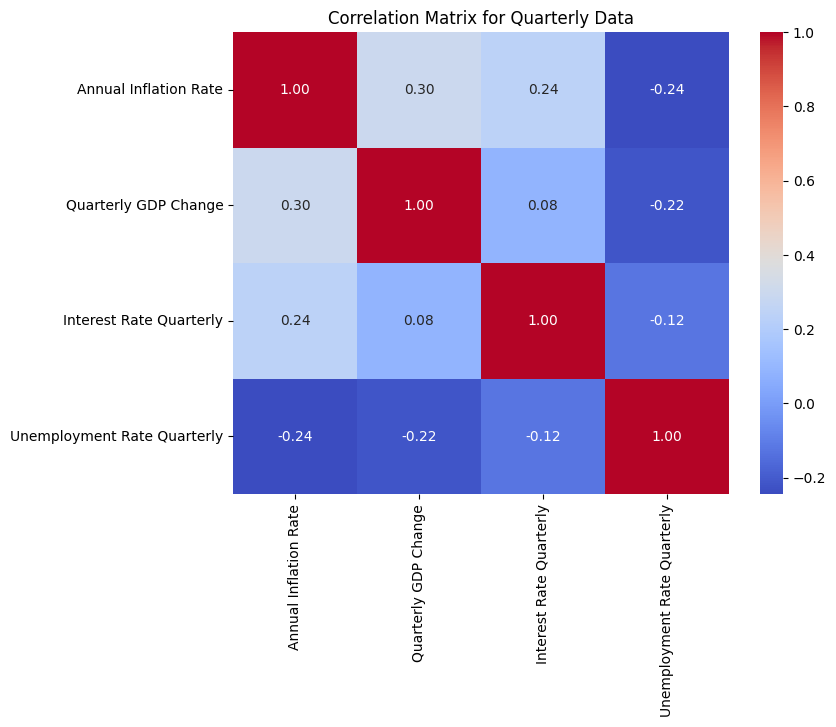

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_quarterly.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Add title
plt.title("Correlation Matrix for Quarterly Data")

# Show the plot
plt.show()

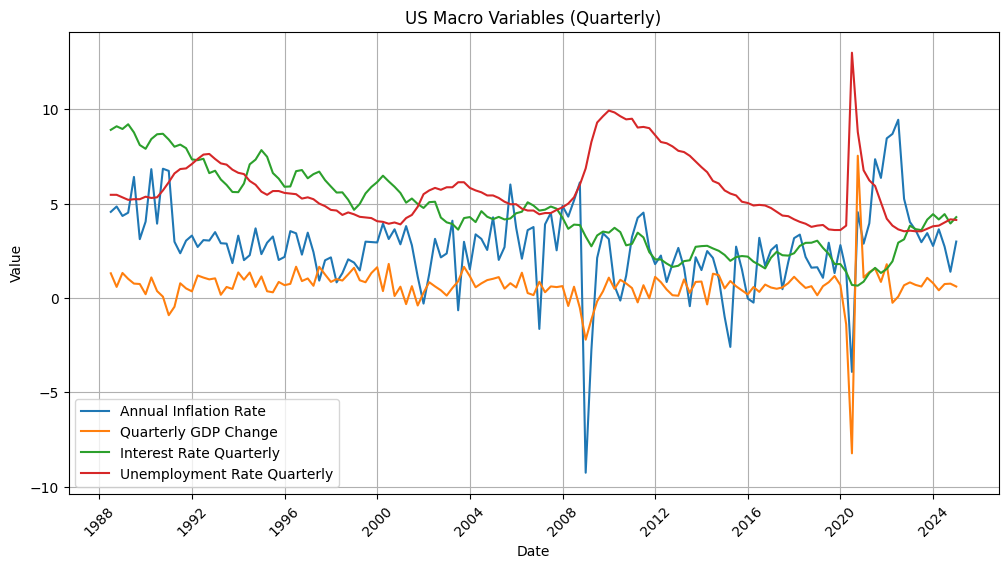

In [78]:
plt.figure(figsize=(12, 6))
for col in df_quarterly.columns:
    plt.plot(df_quarterly.index, df_quarterly[col], label=col)
plt.title('US Macro Variables (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Define exogenous variables using the correct column names from df_combined
exog = df_quarterly[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']].copy()

# Fit the ARDL model
model_ardl = ARDL(df_quarterly['Annual Inflation Rate'], lags=6, exog=exog, order=12, causal=True)
result = model_ardl.fit()

# Display the model summary
print(result.summary())

# Extract p-values and coefficients from the fitted model
pvalues = result.pvalues
coefficients = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs = coefficients[pvalues < 0.05]

print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs)



                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:               ARDL(6, 12, 12, 12)   Log Likelihood                -265.572
Method:                  Conditional MLE   S.D. of innovations              1.591
Date:                   Tue, 15 Apr 2025   AIC                            619.144
Time:                           11:35:52   BIC                            748.889
Sample:                       06-30-1991   HQIC                           671.868
                            - 12-31-2024                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.3906      1.730      0.226      0.822      -3.042       3.824
Annual Inflation Rate.L1            0.2829  

In [82]:
# Check that your start date exists in the data
print(df_quarterly.index)

# Instead of using a specific date string, use the actual index values
# Define Train and Test Sets using existing index values
train_data = df_quarterly.loc[df_quarterly.index < '2022-01-01']  # Use a date you know exists
test_data = df_quarterly.loc[df_quarterly.index >= '2022-01-01']

# Verify the split worked and print the exact index values
print("First test data index value:", test_data.index[0])
print("Test data shape:", test_data.shape)

# Use exact timestamps from the data for forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]

# For exogenous variables, use test_exog instead of exog
test_exog = exog.loc[test_data.index]

# Try the ARDL prediction with exog_oos parameter
pred_ardl = model_ardl.predict(
    params=result.params, 
    start=forecast_start, 
    end=forecast_end, 
    exog_oos=test_exog,  # Use exog_oos for out-of-sample forecasting
    dynamic=True
)

DatetimeIndex(['1988-06-30', '1988-09-30', '1988-12-31', '1989-03-31',
               '1989-06-30', '1989-09-30', '1989-12-31', '1990-03-31',
               '1990-06-30', '1990-09-30',
               ...
               '2022-09-30', '2022-12-31', '2023-03-31', '2023-06-30',
               '2023-09-30', '2023-12-31', '2024-03-31', '2024-06-30',
               '2024-09-30', '2024-12-31'],
              dtype='datetime64[ns]', name='DATE', length=147, freq='QE-DEC')
First test data index value: 2022-03-31 00:00:00
Test data shape: (12, 4)


Inflation is largely self-driven in the short run, with a strong effect from the immediate preceding quarter (L1).

There appears to be a cyclical or corrective dynamic around one year (L4) and beyond (L5).

Other macro variables are not showing strong short-run predictive power once past inflation is included—at least in this specific ARDL model

## Checking for AR lag with no significant ARCH effects and is stationary

In [83]:
max_lag = 12
results = []

for lag in range(1, max_lag + 1):
    model = AutoReg(inflation_rate_series, lags=lag, old_names=False).fit()
    resid = model.resid

    # Check stationarity: For inverse roots, all must be > 1
    stationary = all(np.abs(model.roots) > 1)

    # ARCH test: high p-value (> 0.05)
    arch_p = het_arch(resid)[1]

    # Ljung-Box test at lag 10: high p-value (> 0.05) indicates no autocorrelation
    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

    results.append({
        'lag': lag,
        'AIC': model.aic,
        'BIC': model.bic,
        'Stationary': stationary,
        'ARCH p': arch_p,
        'LB p': lb_p
    })

results_df = pd.DataFrame(results)
print("Candidate AR(p) Models:")
print(results_df)

# Filter models that are stationary and show no significant ARCH effects or autocorrelation effects
filtered_df = results_df[
    (results_df['Stationary']) &
    (results_df['ARCH p'] > 0.05) &
    (results_df['LB p'] > 0.05)
]

print("\nShortlisted Models (Stationary, no ARCH/autocorrelation effects):")
print(filtered_df)

# Choose the best model based on AIC and BIC.
if not filtered_df.empty:
    best_aic = filtered_df.loc[filtered_df['AIC'].idxmin()]
    best_bic = filtered_df.loc[filtered_df['BIC'].idxmin()]
    print(f"\nBest Model by AIC: AR({int(best_aic['lag'])}) with AIC={best_aic['AIC']:.2f} and BIC={best_aic['BIC']:.2f}")
    print(f"Best Model by BIC: AR({int(best_bic['lag'])}) with AIC={best_bic['AIC']:.2f} and BIC={best_bic['BIC']:.2f}")
else:
    print("\nNo AR(p) model from 1 to 12 passed all the diagnostic criteria.")


Candidate AR(p) Models:
    lag         AIC         BIC  Stationary    ARCH p      LB p
0     1  620.326303  629.277123        True  0.997550  0.464901
1     2  618.145542  630.052477        True  0.997675  0.590380
2     3  613.179944  628.029010        True  0.998834  0.772503
3     4  611.091334  628.868402        True  0.998445  0.830146
4     5  604.278845  624.969634        True  0.993733  0.993705
5     6  602.679838  626.269917        True  0.993434  0.994693
6     7  601.189798  627.664580        True  0.994191  0.995804
7     8  596.666846  626.011585        True  0.998415  0.999900
8     9  595.458142  627.657933        True  0.997971  0.999986
9    10  591.304485  626.344256        True  0.998435  0.999999
10   11  588.367183  626.231697        True  0.997753  0.999996
11   12  586.824436  627.498283        True  0.998362  1.000000

Shortlisted Models (Stationary, no ARCH/autocorrelation effects):
    lag         AIC         BIC  Stationary    ARCH p      LB p
0     1  620.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Fra

#### Using best lag 12

AR(12) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                       AutoReg(12)   Log Likelihood                -279.412
Method:                  Conditional MLE   S.D. of innovations              1.917
Date:                   Tue, 15 Apr 2025   AIC                            586.824
Time:                           11:36:55   BIC                            627.498
Sample:                       06-01-1991   HQIC                           603.353
                            - 12-01-2024                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.2800      0.447      2.863      0.004       0.404       2.156
Annual Inflation Rate.L1      0.3876    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


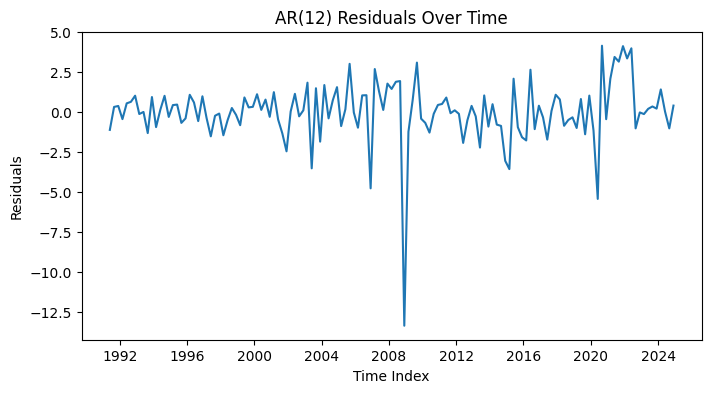

<Figure size 800x400 with 0 Axes>

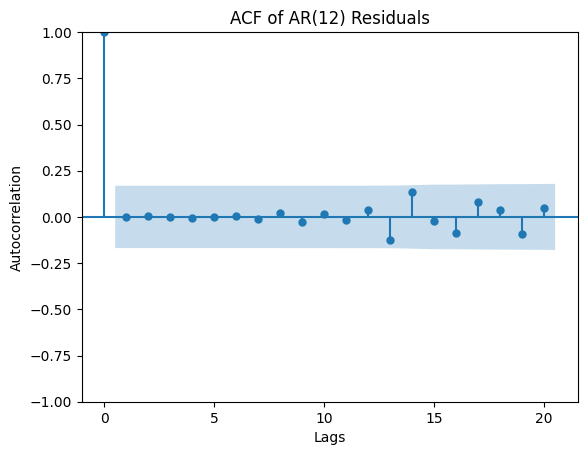

<Figure size 800x400 with 0 Axes>

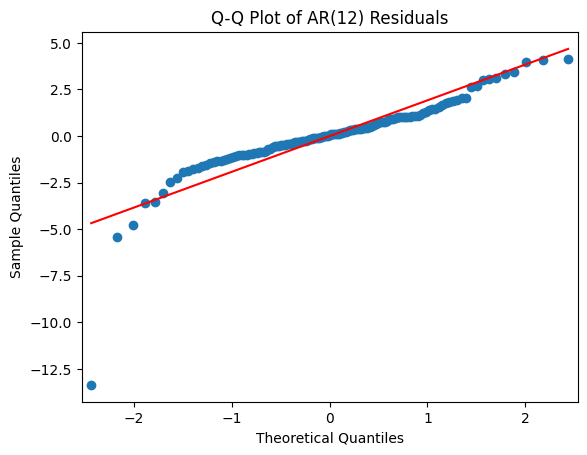

Ljung-Box Test Results for Residuals:
     lb_stat  lb_pvalue
20  9.919788   0.969603


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [84]:
model_ar12 = AutoReg(inflation_rate_series, lags=12, old_names=False).fit()
print("AR(12) Model Summary:")
print(model_ar12.summary())

# Checking residuals
resid_ar12 = model_ar12.resid

# Plot residuals over time
plt.figure(figsize=(8, 4))
plt.plot(resid_ar12)
plt.title("AR(12) Residuals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residuals")
plt.show()

# Plot the ACF of residuals
plt.figure(figsize=(8, 4))
plot_acf(resid_ar12, lags=20, alpha=0.05)
plt.title("ACF of AR(12) Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

# Q-Q plot for residuals
plt.figure(figsize=(8, 4))
sm.qqplot(resid_ar12, line='s')
plt.title("Q-Q Plot of AR(12) Residuals")
plt.show()

# Perform the Ljung-Box test on residuals
lb_test = acorr_ljungbox(resid_ar12, lags=[20], return_df=True)
print("Ljung-Box Test Results for Residuals:")
print(lb_test)

# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]
pred_ar12 = model_ar12.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Plot Actual vs. Forecast
plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar12.index, pred_ar12, label='AR(12) Forecast', color='red')
plt.title("US Annual Inflation Rate Forecast: AR(12)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")

# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=7, rotation=80)

# Tighten the layout to prevent label overlap
plt.tight_layout()

plt.legend()
plt.show()

# Perform the LM test for squared residuals
ar12_squared_resid = resid_ar12 ** 2

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(ar12_squared_resid, lags=12, alpha = 0.05)
plt.title('ACF of AR(12) Squared Residuals')
plt.show()

arch_test_ar12 = het_arch(resid_ar12)
arch_test_results_ar12 = pd.Series(arch_test_ar12, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results_ar12)

# Calculate RMSE for AR(12) model
rmse_ar12 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar12))
print("AR(12) Forecast RMSE: {:.4f}".format(rmse_ar12))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar12.index, pred_ar12, label='AR(12) Forecast', color='red')
plt.title("US Annual Inflation Rate Forecast: AR(12)")
plt.xlabel("Date")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])
plt.ylabel("Inflation Rate (%)")


# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)

plt.legend()
plt.show()

# Calculate RMSE for AR(1) model

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar1.index, pred_ar1, label='AR(1) Forecast')
plt.title("US Annual Inflation Rate Forecast: AR(1)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])

# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)

plt.legend()
plt.show()



In [85]:
# Define the range of lags and orders to test
max_lag = 6  # Maximum lag for the dependent variable
max_order = 12  # Maximum order for the exogenous variables

# Prepare the data
target = df_quarterly['Annual Inflation Rate']
exog = df_quarterly[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]

# Initialize variables to store the best model
best_aic = np.inf
best_bic = np.inf
best_lag = None
best_order = None

# Loop through all combinations of lags and orders
for lag in range(1, max_lag + 1):
    for order in range(1, max_order + 1):
        try:
            # Fit the ARDL model
            model = ARDL(target, lags=lag, exog=exog, order=order, causal=True).fit()
            
            # Get AIC and BIC
            aic = model.aic
            bic = model.bic
            
            # Update the best model based on AIC
            if aic < best_aic:
                best_aic = aic
                best_lag_aic = lag
                best_order_aic = order
            
            # Update the best model based on BIC
            if bic < best_bic:
                best_bic = bic
                best_lag_bic = lag
                best_order_bic = order
        
        except Exception as e:
            # Handle cases where the model fails to fit
            print(f"Error for lag={lag}, order={order}: {e}")

# Print the results
print(f"Best Model by AIC: Lag={best_lag_aic}, Order={best_order_aic}, AIC={best_aic:.4f}")
print(f"Best Model by BIC: Lag={best_lag_bic}, Order={best_order_bic}, BIC={best_bic:.4f}")

Best Model by AIC: Lag=6, Order=2, AIC=607.5379
Best Model by BIC: Lag=5, Order=1, BIC=639.2739


In [86]:
# Define the number of folds
n_initial = 60
print(len(data))
# Prepare the data
data = df_quarterly.copy()
target = data['Annual Inflation Rate']
exog = data[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]

predictions = pd.DataFrame(index=data.index, columns=['AR', 'ARDL', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11','AR12','AR13','AR14'])

# Initialize lists to store RMSE for each fold
ar_rmse = []
ardl_rmse = []
ar_model_rmse = {}

# Perform time series cross-validation
for n in range(n_initial, 140 - 1):
    train_index = np.arange(0, n)
    test_index = np.arange(n, n + 1)
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    train_target, test_target = target.iloc[train_index], target.iloc[test_index]
    train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

    # AR Model
    ar_model = AutoReg(train_target, lags=6, old_names=False).fit()
    ar_forecast = ar_model.predict(start=test_data.index[0], end=test_data.index[-1])
    predictions.loc[test_data.index, 'AR'] = ar_forecast
    
    ar_rmse.append(np.sqrt(mean_squared_error(test_target, ar_forecast)))

    for lag in range(1, 15):
        ar_model = AutoReg(train_target, lags=lag, old_names=False).fit()
        ar_forecast = ar_model.predict(start=test_data.index[0], end=test_data.index[-1])

        if lag not in ar_model_rmse.keys():
            ar_model_rmse[lag] = []

        predictions.loc[test_data.index, 'AR' + str(lag)] = ar_forecast
        ar_model_rmse[lag].append(np.sqrt(mean_squared_error(test_target, ar_forecast)))
    
        
        
    # ARDL Model
    ardl_model = ARDL(train_target, lags=5, exog=train_exog, order=1, causal=True)
    result = ardl_model.fit()
    
    
    ardl_forecast = ardl_model.predict(params=result.params, start=test_data.index[0], end=test_data.index[-1], exog_oos=test_exog)
    ardl_rmse.append(np.sqrt(mean_squared_error(test_target, ardl_forecast)))
    predictions.loc[test_data.index, 'ARDL'] = ardl_forecast
    

# Plot the forecast for each iteration
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Annual Inflation Rate'], label='Actual', color='black')
plt.plot(predictions.index, predictions['AR'], label='AR Forecast', color='blue')
plt.plot(predictions.index, predictions['ARDL'], label='ARDL Forecast', color='red')
plt.title(f"AR vs ARDL Forecast (Fold {len(ar_rmse)})")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.show()

# Plot the forecast for each iteration
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Annual Inflation Rate'], label='Actual', color='black')
plt.plot(predictions.index, predictions['AR1'], label='AR(1) Forecast', color='blue')
plt.plot(predictions.index, predictions['AR10'], label='AR(10) Forecast', color='red')
plt.title(f"AR vs ARDL Forecast (Fold {len(ar_rmse)})")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.show()

# Calculate average RMSE for both models
print(f"Average RMSE for AR Model: {np.mean(ar_rmse):.4f}")
print(f"Average RMSE for ARDL Model: {np.mean(ardl_rmse):.4f}")

for key in ar_model_rmse.keys():
    print(f"Average RMSE for AR({key}): {np.mean(ar_model_rmse[key]):.4f}")


display(predictions['AR1'])
predictions['AR1'].to_csv('AR1.csv')

NameError: name 'data' is not defined

In [87]:
train_exog = exog.iloc[:120]
test_exog = exog.iloc[120:]

train_data = df_inflation['Annual Inflation Rate'].iloc[:120]
test_data = df_inflation['Annual Inflation Rate'].iloc[120:]

print(train_data)
print(test_data)


model_ar1 = AutoReg(train_data, lags=1).fit()
model_ar6 = AutoReg(train_data, lags=6).fit()
model_ar20 = AutoReg(train_data, lags=20).fit()
model_ardl = ARDL(train_data, lags=6, exog=train_exog, order=12, causal=True)
result = model_ardl.fit()

print(model_ar20.summary())
# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]
pred_ar1 = model_ar1.predict(start=forecast_start, end=forecast_end, dynamic=False)
pred_ar6 = model_ar6.predict(start=forecast_start, end=forecast_end, dynamic=False)
pred_ar20 = model_ar20.predict(start=forecast_start, end=forecast_end, dynamic=False)
pred_ardl = model_ardl.predict(params = result.params, start=forecast_start, end=forecast_end, exog_oos=test_exog, dynamic=False)

print(pred_ar6)

DATE
1988-06-01    4.562353
1988-09-01    4.847178
1988-12-01    4.346052
1989-03-01    4.518577
1989-06-01    6.414052
                ...   
2017-03-01    2.805104
2017-06-01    0.461241
2017-09-01    1.907618
2017-12-01    3.169532
2018-03-01    3.356445
Name: Annual Inflation Rate, Length: 120, dtype: float64
DATE
2018-06-01    2.171736
2018-09-01    1.604147
2018-12-01    1.625176
2019-03-01    1.066464
2019-06-01    2.928123
2019-09-01    1.317333
2019-12-01    2.799616
2020-03-01    1.439377
2020-06-01   -3.922562
2020-09-01    4.546453
2020-12-01    2.875203
2021-03-01    3.955483
2021-06-01    7.354926
2021-09-01    6.363107
2021-12-01    8.459982
2022-03-01    8.695480
2022-06-01    9.445552
2022-09-01    5.254760
2022-12-01    4.027827
2023-03-01    3.592992
2023-06-01    2.954175
2023-09-01    3.436468
2023-12-01    2.756113
2024-03-01    3.638664
2024-06-01    2.719364
2024-09-01    1.386308
2024-12-01    2.988338
Name: Annual Inflation Rate, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


ValueError: The indices for endog and exog are not aligned

In [88]:
rmse_ar1 = np.sqrt(mean_squared_error(test_data, pred_ar1))
rmse_ar6 = np.sqrt(mean_squared_error(test_data, pred_ar6))
rmse_ar20 = np.sqrt(mean_squared_error(test_data, pred_ar20))
rmse_ardl = np.sqrt(mean_squared_error(test_data, pred_ardl))

ValueError: Found input variables with inconsistent numbers of samples: [27, 11]

In [89]:
print(rmse_ar1,rmse_ar6,rmse_ar20,rmse_ardl)

NameError: name 'rmse_ar6' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual test data
plt.plot(test_data, label='Actual', color='blue', linewidth=2)

# Plot predictions from AR(6) model
plt.plot(test_data.index, pred_ar20, label='Predicted (ARDL)', color='orange', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate')
plt.title('Actual vs Predicted Inflation Rate (AR6)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
